# Comparison of the tightness of the lower/upper-bounds

In [1]:
import torch
import confounding_robust_inference as cri

In [2]:
from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

/tmp/ipykernel_2359398/966458967.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
beta = torch.as_tensor([1, 0.5, -0.5, 0, 0], dtype=TORCH_DTYPE)
policy = cri.policies.LogisticPolicy(beta)
data = cri.data.SyntheticDataBinary()
Y, T, X, _, p_t, _ = data.sample(4000)

In [4]:
ipw = cri.estimators.IPWEstimator().fit(Y, T, X, p_t, policy).predict()
true_ipw = data.evaluate_policy(policy)
true_lower_bound = data.evaluate_policy_lower_bound(policy, Gamma=1.5)
bias = ipw - true_ipw


def remove_finite_sample_bias(ests):
    return [x - bias for x in ests]

In [5]:
def get_lower_bound_ci(Gamma):
    estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=30)
    estimator.fit(Y, T, X, p_t, policy)
    return estimator.predict_ci()


def get_upper_bound_ci(Gamma):
    estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=30)
    estimator.fit(-Y, T, X, p_t, policy)
    low, high = estimator.predict_ci()
    return -high, -low

In [6]:
Gammas = [1 + i / 10 for i in range(11)]
lower_bound_cis = [get_lower_bound_ci(Gamma) for Gamma in Gammas]
upper_bound_cis = [get_upper_bound_ci(Gamma) for Gamma in Gammas]

In [7]:
lower_bounds = [(l + h) / 2 for (l, h) in lower_bound_cis]
upper_bounds = [(l + h) / 2 for (l, h) in upper_bound_cis]
lower_bound_cis_high = [h for (l, h) in lower_bound_cis]
upper_bound_cis_high = [h for (l, h) in upper_bound_cis]
lower_bound_cis_low = [l for (l, h) in lower_bound_cis]
upper_bound_cis_low = [l for (l, h) in upper_bound_cis]

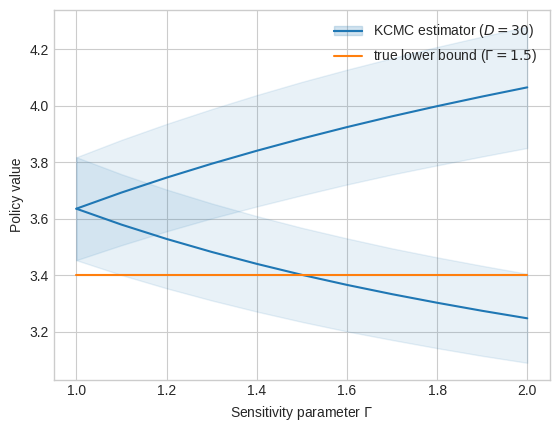

In [8]:
lower_line = plt.plot(Gammas, lower_bounds, color=tab10(0))[0]
upper_line = plt.plot(Gammas, upper_bounds, color=tab10(0))[0]
lower_band = plt.fill_between(
    Gammas, lower_bound_cis_low, lower_bound_cis_high, color=tab10(0), alpha=0.1
)
upper_band = plt.fill_between(
    Gammas, upper_bound_cis_low, upper_bound_cis_high, color=tab10(0), alpha=0.1
)
true_line = plt.plot(Gammas, [true_lower_bound] * 11, c=tab10(1))[0]
plt.legend(
    [(lower_line, upper_line, lower_band, upper_band), (true_line,)],
    ["KCMC estimator ($D=30$)", "true lower bound ($\Gamma=1.5$)"],
)
plt.xlabel(r"Sensitivity parameter $\Gamma$")
plt.ylabel(r"Policy value")
plt.savefig("fig/bound_tightness.pdf")